In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import skforecast
print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.18.0


In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from skforecast.datasets import fetch_dataset
from skforecast.drift_detection import PopulationDriftDetector, PopulationDriftDetector
import nannyml as nml
import matplotlib.pyplot as plt

In [32]:
data = fetch_dataset('bike_sharing')
data.head(3)

# sabe using joblib
import joblib
joblib.dump(data, 'fixture_data_population_drift.joblib')

╭───────────────────────────────── bike_sharing ──────────────────────────────────╮
│ Description:                                                                    │
│ Hourly usage of the bike share system in the city of Washington D.C. during the │
│ years 2011 and 2012. In addition to the number of users per hour, information   │
│ about weather conditions and holidays is available.                             │
│                                                                                 │
│ Source:                                                                         │
│ Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.   │
│ https://doi.org/10.24432/C5W894.                                                │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/bike_sharing_dataset_clean.csv                               │
│                                                                                 │
│ Shape: 17544 rows x 11 columns                                                  │
╰─────────────────────────────────────────────────────────────────────────────────╯

['fixture_data_population_drift.joblib']

In [4]:
data_train = data.iloc[: len(data)//2].copy()
data_new  = data.iloc[len(data)//2 :].copy()
print(f'Train: {data_train.shape}, Test: {data_new.shape}')
data_train['weather'] = data_train['weather'].astype('category')
data_new['weather'] = pd.Categorical(data_new['weather'], categories=data_train['weather'].cat.categories)

Train: (8772, 11), Test: (8772, 11)


In [5]:
# Calculate statistics using nannyml
# =============================================================================
detector = nml.UnivariateDriftCalculator(
    column_names=data_train.columns.tolist(),
    timestamp_column_name="date_time",  # optional if you have time
    chunk_period='M',                   # optional if you have time
    categorical_methods=['chi2', 'jensen_shannon'],
    continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
)
detector.fit(reference_data=data_train.reset_index())
results = detector.calculate(data=data_new.reset_index())

In [6]:
results_nannyml = results.filter(period='analysis').to_df(multilevel=False)
results_nannyml.head(3)

,chunk_key,chunk_index,chunk_start_index,chunk_end_index,chunk_start_date,chunk_end_date,chunk_period,atemp_kolmogorov_smirnov_value,atemp_kolmogorov_smirnov_upper_threshold,atemp_kolmogorov_smirnov_lower_threshold,...,workingday_jensen_shannon_lower_threshold,workingday_jensen_shannon_alert,weather_chi2_value,weather_chi2_upper_threshold,weather_chi2_lower_threshold,weather_chi2_alert,weather_jensen_shannon_value,weather_jensen_shannon_upper_threshold,weather_jensen_shannon_lower_threshold,weather_jensen_shannon_alert
0,2012-01,0,0,731,2012-01-01,2012-01-31 23:59:59.999999999,analysis,0.492026,0.95185,None,...,None,False,2.699410,None,None,False,0.026844,0.447542,None,False
1,2012-02,1,732,1427,2012-02-01,2012-02-29 23:59:59.999999999,analysis,0.489746,0.95185,None,...,None,False,0.319118,None,None,False,0.009387,0.447542,None,False
2,2012-03,2,1428,2171,2012-03-01,2012-03-31 23:59:59.999999999,analysis,0.222809,0.95185,None,...,None,False,9.970343,None,None,True,0.055408,0.447542,None,False


In [7]:
detector = PopulationDriftDetector(
    chunk_size='ME',            
    threshold=0.99
)
detector.fit(data_train)
results_skforecast = detector.predict(data_new)
results_skforecast.head(3)

,chunk,chunk_start,chunk_end,feature,ks_statistic,threshold_ks,chi2_statistic,threshold_chi2,jensen_shannon,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
0,0,2012-01-01 12:00:00,2012-01-31 23:00:00,holiday,0.036162,0.036314,NaN,NaN,0.073079,0.121919,"(0.0, 1.0)",False,False,False,False,False
1,1,2012-02-01 00:00:00,2012-02-29 23:00:00,holiday,0.005071,0.036314,NaN,NaN,0.012252,0.121919,"(0.0, 1.0)",False,False,False,False,False
2,2,2012-03-01 00:00:00,2012-03-31 23:00:00,holiday,0.029412,0.036314,NaN,NaN,0.121919,0.121919,"(0.0, 1.0)",False,False,False,False,False


In [8]:
# Test that statistics are equivalent to nannyml
# =============================================================================
features = results_skforecast["feature"].unique()
for feature in features:
    print(f"Feature: {feature}")
    cols = [
        "chunk_index",
        "chunk_start_date",
        "chunk_end_date",
        f"{feature}_kolmogorov_smirnov_value",
        f"{feature}_jensen_shannon_value",
        f"{feature}_chi2_value",
    ]
    # select columns if they exist in results_skforecast
    cols = [col for col in cols if col in results_nannyml.columns]
    df_nannyml = results_nannyml[cols].copy()
    df_nannyml = df_nannyml.rename(
        columns={
            "chunk_index": "chunk",
            "chunk_start_date": "chunk_start",
            "chunk_end_date": "chunk_end",
            f"{feature}_kolmogorov_smirnov_value": "ks_statistic",
            f"{feature}_jensen_shannon_value": "jensen_shannon",
            f"{feature}_chi2_value": "chi2_statistic",
        }
    )
    df_nannyml["feature"] = feature
    if "chi2_statistic" not in df_nannyml.columns:
        df_nannyml["chi2_statistic"] = np.nan
    if "ks_statistic" not in df_nannyml.columns:
        df_nannyml["ks_statistic"] = np.nan
    if "jensen_shannon" not in df_nannyml.columns:
        df_nannyml["jensen_shannon"] = np.nan

    df_nannyml = df_nannyml[
        [
            "chunk",
            "chunk_start",
            "chunk_end",
            "feature",
            "ks_statistic",
            "chi2_statistic",
            "jensen_shannon",
        ]
    ]

    df_skforecast = results_skforecast.query(f"feature == '{feature}'")[
        [
            "chunk",
            "chunk_start",
            "chunk_end",
            "feature",
            "ks_statistic",
            "chi2_statistic",
            "jensen_shannon",
        ]
    ]

    df_all = pd.merge(
        df_nannyml,
        df_skforecast,
        on=["chunk", "chunk_start", "feature"],
        suffixes=("_nannyml", "_skforecast"),
    )
    pd.testing.assert_series_equal(
        df_all["ks_statistic_nannyml"],
        df_all["ks_statistic_skforecast"],
        check_names=False,
    )
    pd.testing.assert_series_equal(
        df_all["chi2_statistic_nannyml"],
        df_all["chi2_statistic_skforecast"],
        check_names=False,
    )
    pd.testing.assert_series_equal(
        df_all["jensen_shannon_nannyml"],
        df_all["jensen_shannon_skforecast"],
        check_names=False,
    )

Feature: holiday
Feature: workingday
Feature: weather
Feature: temp
Feature: atemp
Feature: hum
Feature: windspeed
Feature: users
Feature: month
Feature: hour
Feature: weekday


In [28]:
# Multiseries
# =============================================================================
series = []
for i in range(20):
    df_temp = data.copy()
    df_temp['series'] = f'series_{i}'
    series.append(df_temp)
series = pd.concat(series)
series = series.set_index('series', append=True).swaplevel().sort_index()
series

temp
series   date_time                 
series_0 2011-01-01 00:00:00   9.84
         2011-01-01 01:00:00   9.02
         2011-01-01 02:00:00   9.02
         2011-01-01 03:00:00   9.84
         2011-01-01 04:00:00   9.84
...                             ...
series_9 2012-12-31 19:00:00  10.66
         2012-12-31 20:00:00  10.66
         2012-12-31 21:00:00  10.66
         2012-12-31 22:00:00  10.66
         2012-12-31 23:00:00  10.66

[350880 rows x 1 columns]

In [29]:
detector = PopulationDriftDetector(
    chunk_size='ME',            
    threshold=0.99
)
detector.fit(series)

In [30]:
series_new = series.copy()
results_skforecast, summary = detector.predict(series_new, return_only_drift=False)
results_skforecast

,series_id,chunk,chunk_start,chunk_end,feature,ks_statistic,threshold_ks,chi2_statistic,threshold_chi2,jensen_shannon,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
0,series_0,0,2011-01-01,2011-01-31 23:00:00,temp,0.728815,0.714146,NaN,NaN,0.725510,0.716488,"(0.8200000000000001, 41.0)",False,True,False,True,True
1,series_0,1,2011-02-01,2011-02-28 23:00:00,temp,0.498872,0.714146,NaN,NaN,0.523879,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
2,series_0,2,2011-03-01,2011-03-31 23:00:00,temp,0.461770,0.714146,NaN,NaN,0.496780,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
3,series_0,3,2011-04-01,2011-04-30 23:00:00,temp,0.179224,0.714146,NaN,NaN,0.347410,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
4,series_0,4,2011-05-01,2011-05-31 23:00:00,temp,0.329803,0.714146,NaN,NaN,0.435507,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,series_9,19,2012-08-01,2012-08-31 23:00:00,temp,0.623599,0.714146,NaN,NaN,0.637729,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
476,series_9,20,2012-09-01,2012-09-30 23:00:00,temp,0.418158,0.714146,NaN,NaN,0.499819,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
477,series_9,21,2012-10-01,2012-10-31 23:00:00,temp,0.232900,0.714146,NaN,NaN,0.459127,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False
478,series_9,22,2012-11-01,2012-11-30 23:00:00,temp,0.494431,0.714146,NaN,NaN,0.561628,0.716488,"(0.8200000000000001, 41.0)",False,False,False,False,False


In [31]:
summary

,n_chunks_with_drift,pct_chunks_with_drift
series_id,,
series_0,1,0.041667
series_1,1,0.041667
series_10,1,0.041667
series_11,1,0.041667
series_12,1,0.041667
series_13,1,0.041667
series_14,1,0.041667
series_15,1,0.041667
series_16,1,0.041667


In [12]:
# from matplotlib import pyplot as plt

# # Plot time series
# fig, ax = plt.subplots(figsize=(8, 3))
# chunck_start = '2012-01-01 22:00:00'
# chunck_end = '2012-01-31 23:00:00'
# data_train.loc[:, 'temp'].plot(ax=ax, label='Train')
# data_new.loc[chunck_start:chunck_end, 'temp'].plot(ax=ax, label='Chunk 0')
# ax.set_title('Temperature Over Time')
# ax.set_xlabel('Date')
# ax.set_ylabel('Temperature')
# ax.legend()

# # Compare distributions using kdeplot
# import seaborn as sns
# feature = 'temp'
# chunk_data = data_new.loc[chunck_start:chunck_end, feature]
# ref_data = data_train[feature]
# plt.figure(figsize=(8, 3))
# sns.kdeplot(ref_data, label='Reference (Train)', color='blue')
# sns.kdeplot(chunk_data, label='Chunk 0', color='red')
# plt.title(f'Distribution Comparison for {feature}')
# plt.xlabel(feature)
# plt.ylabel('Density')
# plt.legend()
# plt.show()

# # Compare cumulative distributions
# plt.figure(figsize=(8, 3))
# sns.ecdfplot(ref_data, label='Reference (Train)', color='blue')
# sns.ecdfplot(chunk_data, label='Chunk 0', color='red')
# plt.title(f'Cumulative Distribution Comparison for {feature}')
# plt.xlabel(feature)
# plt.ylabel('Cumulative Probability')
# plt.legend()
# plt.show()

# # Visual comparison of ranges with violin plot
# plt.figure(figsize=(8, 3))
# min_reference = ref_data.min()
# max_reference = ref_data.max()
# min_chunk = chunk_data.min()
# max_chunk = chunk_data.max()

# plt.figure(figsize=(8, 3))
# plt.plot([min_reference, max_reference], [0, 0], color='blue', linewidth=3)
# plt.vlines([min_reference, max_reference], -0.1, 0.1, color='blue', linewidth=3)
# plt.plot([min_chunk, max_chunk], [1, 1], color='green', linewidth=3)
# plt.vlines([min_chunk, max_chunk], 0.9, 1.1, color='green', linewidth=3)
# plt.yticks([0, 1], ['Reference', 'Chunk'])
# plt.xlabel("Values")
# plt.title("Range of observations")
# plt.gca().invert_yaxis()
# plt.show();

# Plot to compare distrubution of two categorical features
# ==============================================================================
# feature = 'weather'
# chunck_start = '2012-12-01 00:00:00'
# chunck_end = '2012-12-31 23:00:00'
# # Combine reference and chunk into one DataFrame
# df = pd.concat([
#     pd.DataFrame({feature: data_train[feature], 'dataset': 'Reference'}),
#     pd.DataFrame({feature: data_new.loc[chunck_start:chunck_end, feature], 'dataset': 'Chunk 0'})
# ])

# df_counts = (
#     df.groupby(['dataset', feature])
#       .size()
#       .unstack(fill_value=0)  # categories become columns
# )
# df_props = df_counts.div(df_counts.sum(axis=1), axis=0)  # row-wise normalization

# ax = df_props.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='tab20')
# plt.title(f'Stacked Proportion Comparison for {feature}')
# plt.ylabel('Proportion')
# plt.xlabel('Dataset')
# plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


In [13]:
len(data)//2

8772

## Examples

In [14]:
data = fetch_dataset('bike_sharing', verbose=False)
data = data[['temp']]
data_train = data.iloc[: 9000].copy()
data_new  = data.iloc[9000:].copy()
print(f'Train: {data_train.shape}, Test: {data_new.shape}')

Train: (9000, 1), Test: (8544, 1)


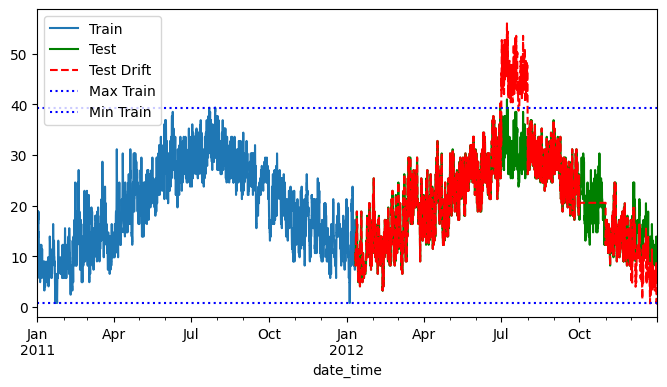

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
data_train.loc[:, 'temp'].plot(ax=ax, label='Train')
data_new.loc[:, 'temp'].plot(ax=ax, label='Test', color='green')

data_new_drift = data_new.copy()
# Sum +20 to observations of july 2012
data_new_drift.loc['2012-07-01 00:00:00':'2012-07-31 23:00:00', 'temp'] = (
    data_new_drift.loc['2012-07-01 00:00:00':'2012-07-31 23:00:00', 'temp'] + 15
)

# CConstant mean value in October 2012
data_new_drift.loc['2012-10-01 00:00:00':'2012-10-31 23:00:00', 'temp'] = (
    data_new_drift.loc['2012-10-01 00:00:00':'2012-10-31 23:00:00', 'temp'].mean()
)

# Substract -10 to december 2012
data_new_drift.loc['2012-12-01 00:00:00':'2012-12-31 23:00:00', 'temp'] = (
    data_new_drift.loc['2012-12-01 00:00:00':'2012-12-31 23:00:00', 'temp'] - 5
)


data_new_drift.loc[:, 'temp'].plot(ax=ax, label='Test Drift', linestyle='--', color='red')
ax.axhline(data_train['temp'].max(), color='blue', linestyle=':', label='Max Train')
ax.axhline(data_train['temp'].min(), color='blue', linestyle=':', label='Min Train')
ax.legend();

In [26]:
detector = PopulationDriftDetector(
    chunk_size='ME',            
    threshold=0.95
)
detector.fit(data_train)
results_skforecast = detector.predict(data_new_drift, return_only_drift=True)
results_skforecast

,chunk,chunk_start,chunk_end,feature,ks_statistic,threshold_ks,chi2_statistic,threshold_chi2,jensen_shannon,threshold_js,reference_range,is_out_of_range,drift_ks_statistic,drift_chi2_statistic,drift_js,drift_detected
5,5,2012-06-01,2012-06-30 23:00:00,temp,0.504222,0.682966,NaN,NaN,0.551198,0.689223,"(0.8200000000000001, 39.36)",True,False,False,False,True
6,6,2012-07-01,2012-07-31 23:00:00,temp,0.999333,0.682966,NaN,NaN,0.995447,0.689223,"(0.8200000000000001, 39.36)",True,True,False,True,True
9,9,2012-10-01,2012-10-31 23:00:00,temp,0.537556,0.682966,NaN,NaN,0.863793,0.689223,"(0.8200000000000001, 39.36)",False,False,False,True,True
11,11,2012-12-01,2012-12-31 23:00:00,temp,0.687620,0.682966,NaN,NaN,0.673864,0.689223,"(0.8200000000000001, 39.36)",True,True,False,False,True
